<a href="https://colab.research.google.com/github/NRiccieri/HIAAC_Project_Group3/blob/main/FL_proposta_algoritmo_compressao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FL Compression Algorithm**

**Experiment parameters**

In [16]:
#FL environment parameters

num_clients = 35   #total number of devices in the FL environment
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

num_clients_considered = int(num_clients*percentage_clients_considered)
num_clients_selected = int(percentage_clients_selected*num_clients_considered)


#training parameters
num_iterations_per_round = 10 #number of iterations executed by clients at each round of the algorithm

max_num_rounds = 200

validation_size = 0.15

epsilon = 0.0 #difference between the trained FL global model accuracy score and the centralised model accuracy score

accuracy_score_target = 0.91

Note: In the centralized training, given the architecture used (3 hidden layers with 256 units), we reach an accuracy score of about 98.5% in 120 epochs on the training set. **The accuracy score on the testing data is around 91%.** The training time is 2 minutes 22 seconds.

**In the Federated Learning environment, the goal is for the global model located in the central server to be as close as possible to an accuracy score of 91% on the test data.**


## **Importing the dataset from Kaggle**

In [3]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
#create gdrive folder inside content
from google.colab import drive
drive.mount('/content/gdrive')

#importing dataset to google colab from gdrive
!cp /content/gdrive/MyDrive/kaggle_datasets/archive.zip  /content/archive.zip 

#unzipping 
!unzip archive.zip 

Mounted at /content/gdrive
Archive:  archive.zip
  inflating: test.csv                
  inflating: train.csv               


In [5]:
#train dataset that will be split between all clients
df_train = pd.read_csv('train.csv')

x_train = pd.DataFrame(df_train.drop(['Activity','subject'],axis=1))
y_train = df_train.Activity.values.astype(object)

#test dataset that will be located in central server
df_test = pd.read_csv('test.csv')

central_server_data_x = pd.DataFrame(df_test.drop(['Activity','subject'],axis=1))
central_server_data_y_true = df_test.Activity.values.astype(object)

In [6]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

encoder=preprocessing.LabelEncoder()

encoder.fit(y_train)
y_train = encoder.transform(y_train)
print(encoder.classes_)

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)

#scaling central server dataset
central_server_data_x = scaler.transform(central_server_data_x)
central_server_data_y_true = encoder.transform(central_server_data_y_true)

#creating the datasets
#x_test/y_test could be used by server to check gloabl model accuracy
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=100)

['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


## **Creating datasets for each client**

In [7]:
#returns an object with clientID as key, and its dataset
def returnDatasetPerClientObject(x, y):
  datasetObject = []

  n = x.shape[0]
  m = int(n/num_clients)

  i = 0
  while i < num_clients:
    client_i_x = x[ m * i :  m * (i + 1) ]
    client_i_y = y[ m * i :  m * (i + 1) ]
    datasetObject.append({"x": client_i_x, "y": client_i_y})
    i +=1

  return datasetObject


#returns the dataset x/y of a client
def returnDatasetForClient(clientid, datasetObject):
  return {"x" : datasetObject[clientid]["x"] , "y" : datasetObject[clientid]["y"]}


## **Dataset distribution analysis**

In [9]:
import numpy as np
from scipy.stats import kruskal

clients_dataset = returnDatasetPerClientObject(x_train, y_train)

clientIDs_list = [0, 1, 2, 3]
client_y_list = []

for client_id in clientIDs_list:
  client_data = returnDatasetForClient(client_id, clients_dataset)
  client_y_list.append(client_data["y"])


kruksal_test = kruskal(client_y_list[0],client_y_list[1],client_y_list[2],client_y_list[3])
print("Test statistic: Chi^2 = ", kruksal_test.statistic, ", p =", kruksal_test.pvalue)

Test statistic: Chi^2 =  17.989495330776183 , p = 0.0004420493148934156


## **Machine learning model implementation**

**In TensorFlow**

**Functions in central server side**

In [10]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt


def returnInitialGlobalModel():

  model = Sequential([
      
      # reshape 28 row * 28 column data to 28*28 rows
      Flatten(input_shape=(561,), name="inputlayer"),
      
      # dense layer 1
      Dense(256, activation='sigmoid', name="firstlayer"),  
      
      # dense layer 2
      Dense(256, activation='sigmoid', name="secondlayer"), 

      # dense layer 3
      Dense(256, activation='sigmoid', name="thirdlayer"), 
      
      # output layer
      Dense(6, activation='sigmoid', name="outputlayer"),  
  ])

  model.compile(optimizer='sgd',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model


#returns a copy of the global model to client
def returnCopyGlobalModelToClient(globalmodel):

  clientmodel = returnInitialGlobalModel()
  clientmodel.set_weights(globalmodel.get_weights()) 

  return clientmodel


#function that returns the accuracy score of the global model on the client's data
def evaluateGlobalModel(globalmodel, x, y):
  
  results = globalmodel.evaluate(x, y, verbose=0)

  return results[1]


#function that uncompresses the gradient from the clients
def uncompressClientsGradient(clientscompressedgradientobject):

  clientsUncompressedradientobject = clientscompressedgradientobject
  
  return clientsUncompressedradientobject

#add the client gradient to the global model
def addGradient(modelNotTrained, gradient):
  newWeight = []
  i = 0
  notTrainedWeight = modelNotTrained.get_weights()
  for weight in modelNotTrained.get_weights():
    newWeight.append( weight - (gradient[i] / num_clients_selected) )
    i += 1
  modelNotTrained.set_weights(newWeight)


# #update the central server model with the gradient from clients
# def updateGlobalModelWeights(globalmodel, clientsgradientobject):

#   for clientgradient in clientsgradientobject:
#     i = 0
#     for layer in globalmodel.layers:
#       if i >= 1:
#         j = 0
#         for weight in layer.weights:
#           current_weights = layer.weights[j]
#           globalmodel.layers[i].weights[j] = current_weights - clientgradient["clientgradient"].layers[i].weights[j] / num_clients_selected
#           j += 1
#       i +=1

**Functions in clients side**

In [11]:
#returns the compressed gradient to be sent to central server
def compressGradient(clientgradient):
  
  compressedclientgradient = clientgradient
  return compressedclientgradient

#Given the weights after training and initial weights, returns the gradient from entire training
def computeClientGradient(modelNotTrained, modelTrained):
  gradient = []
  notTrainedWeight = modelNotTrained.get_weights()
  i = 0
  for weight in modelTrained.get_weights():
    gradient.append( notTrainedWeight[i] - weight )
    i += 1
  return gradient

## **Central server logic implementation**

In [12]:
import random


#Generate a random list of clients considered of length num_clients_considered
def returnRandomSelectedClientsIDsList():
  return random.sample(range(0, num_clients), num_clients_considered)


#function that returns the evaluation of the global model on the selected clients
def returnWorstLossesAmongChosenClients(classifierModel, chosenClients, datasetObject):
  
  clients_accuracy_list = [] #modelEvaluationObject()
  j = 0 
  
  #evaluate the classifier on each random client's data
  while j < len(chosenClients):
    
    client_id = chosenClients[j]
    client_dataset = returnDatasetForClient(client_id, datasetObject)
    client_accuracy_score = evaluateGlobalModel(classifierModel, client_dataset["x"], client_dataset["y"])
    
    clients_accuracy_list.append({"clientID": client_id, "accuracy": client_accuracy_score})

    j+= 1

  #order the losses from worst to best
  clients_accuracy_list.sort(key=lambda x: x["accuracy"], reverse=False)

  return clients_accuracy_list



#main code running on server side
def runTraining(classifierModel, accuracyScoreTarget, clientsDatasetObject):

  #We first evaluate the global model
  globalAccuracy = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)
  
  print("Starting")
  print("Before training global model accuracy =", globalAccuracy)
  print()

  i = 0
  accuracy_score = 0
  per_round_global_model_accuracy = []

  while i < max_num_rounds:

      print("Round ", i + 1, " / Max rounds ", max_num_rounds)
      
      #select random clients
      random_clients = returnRandomSelectedClientsIDsList()

      #return the list of clients with loss value from worst to best
      pretraining_loss_values_obj = returnWorstLossesAmongChosenClients(classifierModel, random_clients, clientsDatasetObject)


      print("Model evaluation on clients : ", pretraining_loss_values_obj)
      print("Selected clients :", pretraining_loss_values_obj[:num_clients_selected])

      selected_clients_grad_list = []
      
      ##################
      #At client
      ##################

      #training classifier on each client
      for selected_client in pretraining_loss_values_obj[:num_clients_selected]:
        
        client_id = selected_client["clientID"]
        
        #making a copy of the classifier from central server
        client_model = returnCopyGlobalModelToClient(classifierModel)
        
        #training the global model on client's local data
        client_data = returnDatasetForClient(client_id, clientsDatasetObject)
        client_model.fit(client_data["x"], client_data["y"], epochs = num_iterations_per_round, 
          validation_split = validation_size, verbose=0)

        #getting the gradient from the client
        client_gradient = computeClientGradient(classifierModel, client_model)
        
        #should compress the gradient before sending the client's gradient to central server
        compressed_client_gradient = compressGradient(client_gradient)

        #storing the gradients to be sent to central server
        selected_clients_grad_list.append( {"clientID": client_id, "clientgradient": compressed_client_gradient} )



      ##################
      #At central server
      ##################

      #uncompress the gradient from clients
      selected_clients_grad_list = uncompressClientsGradient(selected_clients_grad_list)

      #updating the global model weights
      for client_gradient in selected_clients_grad_list:
        addGradient(classifierModel, client_gradient["clientgradient"])

      #evaluating the global model on data contained in central server
      globalAccuracy = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)

      per_round_global_model_accuracy.append(globalAccuracy)

      print("Current global model accuracy score = ", globalAccuracy)
      print()  

      if globalAccuracy >= accuracyScoreTarget - epsilon:
        print("")
        print("Global model converged")
        print("Convergence accuracy score = ", globalAccuracy)
        break

      i += 1

  #plot the results 
  print("Number of clients :", num_clients)
  print("Number of clients participating per round :", num_clients_considered)
  print("Number of clients training the model per round : ", num_clients_selected)
  print("Number of iterations per client per round : ", num_iterations_per_round)

  plt.plot(per_round_global_model_accuracy)
  plt.ylabel('Accuracy per epoch')
  plt.show()


  return [classifierModel, per_round_global_model_accuracy]


## **Experiments**

Same experiment as above but with all clients considered participating in the training.

Objective: see that Power-of-Selection converges faster by focusing on clients with worst accuracy scores.

Starting
Before training global model accuracy = 0.18052256107330322

Round  1  / Max rounds  200
Model evaluation on clients :  [{'clientID': 3, 'accuracy': 0.13333334028720856}, {'clientID': 11, 'accuracy': 0.1428571492433548}, {'clientID': 31, 'accuracy': 0.14761905372142792}, {'clientID': 21, 'accuracy': 0.15714286267757416}, {'clientID': 13, 'accuracy': 0.17142857611179352}, {'clientID': 30, 'accuracy': 0.17142857611179352}, {'clientID': 0, 'accuracy': 0.25238096714019775}]
Selected clients : [{'clientID': 3, 'accuracy': 0.13333334028720856}, {'clientID': 11, 'accuracy': 0.1428571492433548}, {'clientID': 31, 'accuracy': 0.14761905372142792}]
Current global model accuracy score =  0.16932474076747894

Round  2  / Max rounds  200
Model evaluation on clients :  [{'clientID': 4, 'accuracy': 0.12380952388048172}, {'clientID': 14, 'accuracy': 0.12380952388048172}, {'clientID': 12, 'accuracy': 0.13333334028720856}, {'clientID': 23, 'accuracy': 0.13809524476528168}, {'clientID': 33, 'accu

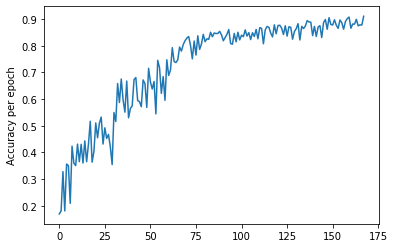

In [17]:
#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()

final_global_model, accuracy_history_poc = runTraining(initial_global_model, accuracy_score_target , clients_dataset)

Starting
Before training global model accuracy = 0.18154054880142212

Round  1  / Max rounds  200
Model evaluation on clients :  [{'clientID': 31, 'accuracy': 0.14761905372142792}, {'clientID': 23, 'accuracy': 0.1666666716337204}, {'clientID': 24, 'accuracy': 0.17619048058986664}, {'clientID': 22, 'accuracy': 0.19523809850215912}, {'clientID': 15, 'accuracy': 0.20476190745830536}, {'clientID': 19, 'accuracy': 0.20952381193637848}, {'clientID': 0, 'accuracy': 0.25238096714019775}]
Selected clients : [{'clientID': 31, 'accuracy': 0.14761905372142792}, {'clientID': 23, 'accuracy': 0.1666666716337204}, {'clientID': 24, 'accuracy': 0.17619048058986664}]
Current global model accuracy score =  0.18221920728683472

Round  2  / Max rounds  200
Model evaluation on clients :  [{'clientID': 4, 'accuracy': 0.1190476194024086}, {'clientID': 3, 'accuracy': 0.13333334028720856}, {'clientID': 26, 'accuracy': 0.16190476715564728}, {'clientID': 12, 'accuracy': 0.16190476715564728}, {'clientID': 33, 'accu

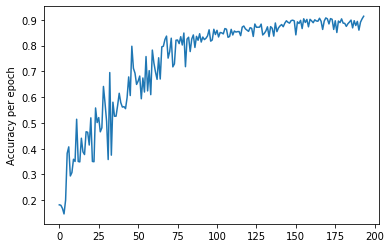

In [13]:
percentage_clients_selected = 1.0


#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()

final_global_model, accuracy_history__all_parti_clients_training = runTraining(initial_global_model, accuracy_score_target , clients_dataset)

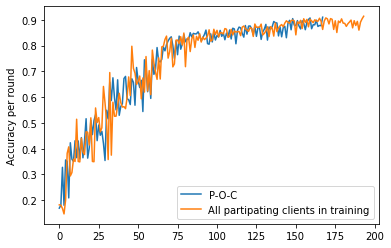

In [18]:
plt.plot(accuracy_history_poc)
plt.plot(accuracy_history__all_parti_clients_training)
plt.ylabel('Accuracy per round')
plt.legend(["P-O-C", "All partipating clients in training"])
plt.show()

In Power-of-Choice seletection, the algorithm reaches convergence after 168 rounds. If no selection is made on the clients, and consider all participating clients for training, then the convergence is reached after 194 rounds. 